In [48]:
import random
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import os
import json
import pandas as pd
%matplotlib inline

In [49]:
def get_param_dict(input_path, expt_name):
    with open(os.path.join(input_path,'{}.json'.format(expt_name))) as f:
        param_dict = json.load(f)
    return param_dict

In [50]:
def generate_reward_dist(mean_rdist, sd_rdist, num_levers):
    mean_reward_vec = [random.normalvariate(mu=mean_rdist,sigma=sd_rdist**2) for i in range(num_levers)]
    sd_reward_vec = [sd_rdist for i in range(num_levers)]
    # lever_vec = list(range(num_levers))
    return mean_reward_vec,sd_reward_vec

In [51]:
def generate_reward_dist_nonstat(mean_rdist,sd_rdist,num_levers,num_steps,noise_time = 0.01):
    reward_means = np.zeros((num_steps,num_levers))
    reward_means[0,:] = mean_rdist # To get equal means
    for i in range(num_steps-1):
        reward_means[i,:] = reward_means[i-1,:] + np.transpose(np.array([random.normalvariate(mu=0,sigma=noise_time) for i in range(num_levers)]))
    sd_reward_vec = [sd_rdist for i in range(num_levers)]
    return reward_means,sd_reward_vec

In [52]:
def plot_distributions(num_levers,mean_reward_vec,sd_reward_vec,output_path,expt_name):
    x = np.linspace(-2,2,100)
    pdf = [np.zeros(shape=x.shape) for i in range(num_levers)]
    count = 0
    plt_1 = plt.figure(figsize=(12,4))
    for m,s in zip(mean_reward_vec,sd_reward_vec):
        pdf[count] += stats.norm.pdf(x, m, s)
        plt.plot(x, pdf[count],label = 'lever_{}'.format(count+1),)
        count += 1

    plt.xlabel("Reward")
    plt.ylabel("Probability")
    plt.title("MAB lever reward distributions")
    plt.legend()
    plt.savefig(os.path.join(output_path,expt_name,"reward_lever_distribtion.png"))
    plt.show()


In [53]:
# Pre-incremental attempt at MAB simulation
def get_run(num_steps, num_levers, mean_reward, sd_reward_vec, eps,stationary = False):
    '''
    At each step, choose a random action from entire set with probability epsilon, else choose greedy action
    '''
    reward_matrix = np.zeros((num_steps,num_levers))
    idx_count = np.zeros(num_levers)
    reward_vec = np.zeros(num_steps)
    optimal_choice_vec = np.zeros(num_steps)
    for i in range(num_steps):

        # First use the sample average method to get the current Q estimates & the greedy index
        current_expected_reward = np.sum(reward_matrix[:i,:],axis=0)/idx_count
        nan_idx = np.where(current_expected_reward == np.nan)
        if len(nan_idx) > 0:
            for idx in nan_idx:
                current_expected_reward[idx] = -np.inf
        
        greedy_ind = np.argmax(current_expected_reward)

        # Now use epsilon to choose explore v/s exploit option
        eps1 = np.random.random_sample()
        if eps >= eps1:
            act_ind = np.random.random_integers(low=0,high=num_levers-1)
            idx_count[act_ind] += 1
        else:
            act_ind = greedy_ind
        
        # Update reward matrix and reward vector basis the chosen lever/action
        if not(stationary):
            mean_reward_vec = np.transpose(mean_reward[i,:])
        else:
            mean_reward_vec = mean_reward


        act_ind_reward = np.random.normal(mean_reward_vec[act_ind],sd_reward_vec[act_ind],1)
        reward_matrix[i,act_ind] = act_ind_reward
        reward_vec[i] = act_ind_reward
        optimal_choice_vec[i] = idx_count[greedy_ind]/(i+1)

    return reward_vec,optimal_choice_vec


In [54]:
def get_run_incremental(num_steps, num_levers, mean_reward, sd_reward_vec, eps,stationary):
    '''
    A simple bandit algorithm
    Initialize, for a = 1 to k:
    Q(a) = 0
    N(a) = 0
    Loop forever:
        A -> argmaxa Q(a) with probability 1 - eps (break ties randomly)
            a random action with probability eps
        R -> bandit(A)
        N(A) = N(A) + 1
        Q(A) = Q(A) + (1/N(A))*(R-Q(A))
    '''
    q_vec = np.zeros(num_levers)
    idx_count = np.zeros(num_levers)
    # act_greedy_ind = np.argmax(mean_reward_vec)
    optimal_choice_vec = np.zeros(num_steps)
    reward_vec = np.zeros(num_steps)
    # reward_matrix = np.zeros((num_steps,num_levers))
    for i in range(num_steps):
        eps1 = np.random.random_sample()
        greedy_ind = np.argmax(q_vec)
        if eps >= eps1:
            act_ind = np.random.random_integers(low=0,high=(num_levers-1))
        else:
            act_ind = greedy_ind
        
        idx_count[act_ind] += 1
        if not(stationary):
            mean_reward_vec = np.transpose(mean_reward[i,:])
        else:
            mean_reward_vec = mean_reward

        act_ind_reward = np.random.normal(mean_reward_vec[act_ind],sd_reward_vec[act_ind],1) # R
        current_estimate = q_vec[act_ind]
        step_size = 1.0/idx_count[act_ind]
        q_vec[act_ind]  = current_estimate + step_size*(act_ind_reward - current_estimate)
        reward_vec[i] = act_ind_reward # Set reward equal to R
        optimal_choice_vec[i] = idx_count[greedy_ind]/(i+1)
        # reward_matrix[i,act_ind] = act_ind_reward

    return reward_vec,optimal_choice_vec

In [55]:
def get_ensemble(num_runs,num_steps,num_levers, mean_reward_vec,sd_reward_vec, eps,incremental = False,stationary=True):
    out_array = np.zeros((num_steps,num_runs))
    out_array_prob = np.zeros((num_steps,num_runs))
    for i in range(num_runs):
        if incremental:
            out_array[:,i], out_array_prob[:,i] = get_run_incremental(num_steps,num_levers,mean_reward_vec,sd_reward_vec,eps,stationary)
        else:
            out_array[:,i], out_array_prob[:,i] = get_run(num_steps,num_levers,mean_reward_vec,sd_reward_vec,eps,stationary)

    out_vec = np.mean(out_array,axis = 1)
    out_vec_prob = np.mean(out_array_prob,axis = 1)
    return out_vec, out_vec_prob

In [56]:
# Run simulation for different values of epsilon

def run_comparison(num_runs,num_steps,num_levers, mean_reward_vec,sd_reward_vec, eps_vec,incremental,stationary=True):
    vec_dict = dict()
    vec_prob_dict = dict()
    for eps in eps_vec:
        vec_dict[eps],vec_prob_dict[eps]= get_ensemble(num_runs,num_steps,num_levers, mean_reward_vec,sd_reward_vec, eps,incremental,stationary)

    return vec_dict,vec_prob_dict

In [57]:
# Plot results
def plot_comparison_rewards(vec_dict,output_path,expt_name):
    plt_1 = plt.figure(figsize=(10,8))
    for key,val in vec_dict.items():
        plt.plot(val, label = 'eps = {}'.format(key))

    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    plt.title("MAB Testbed results")
    plt.legend()
    plt.savefig(os.path.join(output_path,expt_name,"mab_testbed_rewards.png"))
    plt.show()


In [58]:
# Plot results
def plot_comparison_optimal_prob(vec_dict,output_path,expt_name):
    plt_1 = plt.figure(figsize=(10,8))
    for key,val in vec_dict.items():
        plt.plot(val, label = 'eps = {}'.format(key))

    plt.xlabel("Steps")
    plt.ylabel("% Optimal Choice")
    plt.title("MAB Testbed results - ")
    plt.legend()
    plt.savefig(os.path.join(output_path,expt_name,"mab_testbed_optimal_choice.png"))
    plt.show()

In [67]:
def run_expt(input_path,output_path,expt_name):
    param_dict = get_param_dict(input_path, expt_name)
    # Reading the parameters
    num_levers = param_dict['num_levers']
    mean_rdist = param_dict['mean_rdist']
    sd_rdist = param_dict['sd_rdist']
    num_steps = int(param_dict['num_steps'])
    num_runs = int(param_dict['num_runs'])
    eps_vec = param_dict['eps_vec']
    incremental = param_dict['incremental']
    stationary = param_dict['stationary']
    noise_time = param_dict['noise_time']
    # random.seed(123)
    if stationary:
        mean_reward,sd_reward_vec = generate_reward_dist(mean_rdist,sd_rdist,num_levers)
        plot_distributions(num_levers,mean_reward,sd_reward_vec,output_path,expt_name)

    else:
        mean_reward,sd_reward_vec = generate_reward_dist_nonstat(mean_rdist,sd_rdist,num_levers,num_steps,noise_time)
        mean_reward_df = pd.DataFrame(mean_reward,columns=[str(x) for x in list(range(num_levers))])
        mean_reward_df.to_csv(os.path.join(output_path,expt_name,"Nonstationary_mean_df.csv"),index = None)

    vec_dict,vec_prob_dict = run_comparison(num_runs, num_steps, num_levers, mean_reward, sd_reward_vec, eps_vec,incremental,stationary)
    plot_comparison_rewards(vec_dict,output_path,expt_name)
    plot_comparison_optimal_prob(vec_prob_dict,output_path,expt_name)
    config_json_path = os.path.join(output_path,expt_name,'input_config.json')
    with open(config_json_path,'w') as f:
        json.dump(param_dict,f)

    vec_df = pd.DataFrame(vec_dict)
    vec_df.to_csv(os.path.join(output_path,expt_name,"Testbed_Results.csv"),index = None)

c:\Users\91820\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: This function is deprecated. Please call randint(0, 9 + 1) instead


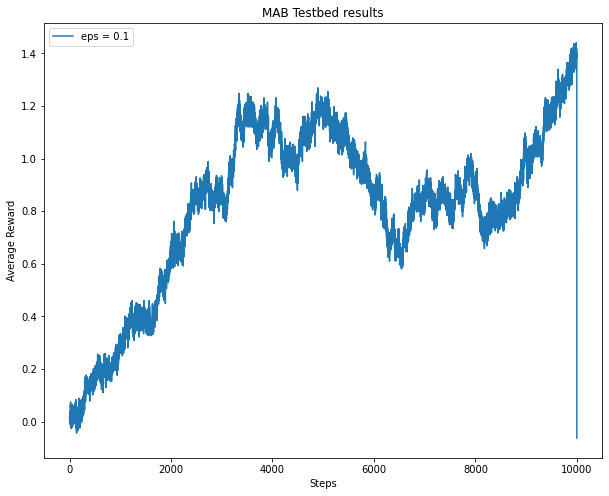

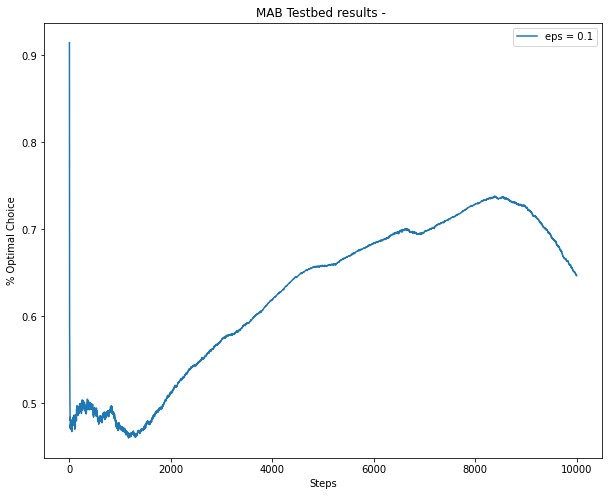

In [68]:
input_path = "C://Data/ds/RL/rlbook/ch1/mab_testbed/inputs"
output_path = "C://Data/ds/RL/rlbook/ch1/mab_testbed/outputs"
expt_name = "ex_2.5_sample_av"

if os.path.exists(os.path.join(output_path,expt_name)):
    print("Experiment already run before - delete old directory or rename experiment file")
else:
    os.mkdir(os.path.join(output_path,expt_name))
    run_expt(input_path,output_path,expt_name)